In [1]:
!pip install -q transformers datasets tokenizers

# Transformers

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.optim as optim
import torch.nn as nn

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Датасет, который мы будем использовать – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [5]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (C:\Users\lugre\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [6]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [9]:
emotion_dataset["train"]["label"][0]

0

In [10]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [11]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token  # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

In [12]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [13]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [15]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

Определим максимальную длину текста в датасете:

In [16]:
def max_text_len(texts, tokenizer):
    max_len = 0
    for text in texts:
        cur_len = len(tokenizer.encode(text))
        if cur_len > max_len:
            max_len = cur_len
    return max_len

print(f'Максимальная длина текста в датасете train = {max_text_len(emotion_dataset["train"]["text"], tokenizer)}')
print(f'Максимальная длина текста в датасете validation = {max_text_len(emotion_dataset["validation"]["text"], tokenizer)}')
print(f'Максимальная длина текста в датасете test = {max_text_len(emotion_dataset["test"]["text"], tokenizer)}')

Максимальная длина текста в датасете train = 86
Максимальная длина текста в датасете validation = 67
Максимальная длина текста в датасете test = 62


In [17]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0],
                      max_length=86,         # максимальная длина текста
                      padding="max_length",  # надо ли добавлять паддинг в конце?
                      return_tensors="pt")   # возвращает pytorch тензоры

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
# Предварительная токенизация части датасета позволяет значительно снизить время обучение модели
# В моём случае время обучения снизилось с 10 до 2 минут на одной эпохе

class TweetDataset(Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.texts = self.dataset[self.part]["text"]
        self.labels = self.dataset[self.part]["label"]
        self.max_length = self.get_max_len(self.texts, self.tokenizer)
        self.indexes, self.masks = self.tokenize_data(self.texts, self.tokenizer)
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """

        return {
            "input_ids": self.indexes[idx],
            "attention_mask": self.masks[idx],
            "target": self.labels[idx]
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

    def get_max_len(self, texts, tokenizer):
        max_len = 0
        for text in texts:
            cur_len = len(tokenizer.encode(text))
            if cur_len > max_len:
                max_len = cur_len

        return max_len

    def tokenize_data(self, texts, tokenizer):
        indexes = []
        masks = []
        for text in texts:
            tokenized_data = tokenizer.encode_plus(
                             text=text,
                             max_length=self.max_length,  # максимальная длина текста
                             padding="max_length",        # надо ли добавлять паддинг в конце?
                             return_tensors="pt",         # возвращает pytorch тензоры
                             )

            indexes.append(tokenized_data['input_ids'])
            masks.append(tokenized_data['attention_mask'])

        return indexes, masks

In [20]:
train_dataset = TweetDataset("train")       # train
valid_dataset = TweetDataset("validation")  # validation
test_dataset = TweetDataset("test")         # test

In [21]:
batch_size = 32 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [22]:
num_classes = len(np.unique(emotion_dataset["train"]["label"]))  # 6

In [23]:
config = GPT2Config.from_pretrained(
    "distilgpt2",  # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=num_classes
)
model_0 = GPT2ForSequenceClassification(config=config).to(device)  # GPT2 для классификации текста

In [24]:
lr = 1e-5  

optimizer = optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [46]:
train_data_iter = next(iter(train_loader))

tokens = train_data_iter["input_ids"]     
mask = train_data_iter["attention_mask"]  

output = model_0(input_ids=tokens.squeeze(1).to(device), attention_mask=mask.squeeze(1).to(device)) 
output.keys()

odict_keys(['logits', 'past_key_values', 'attentions'])

In [47]:
output.logits.shape

torch.Size([32, 6])

In [25]:
num_epochs = 15
best_valid_acc = 0
train_losses = []
valid_losses = []

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    processed_data_train = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["attention_mask"].squeeze(1).to(device)
        target = batch["target"].to(device)

        output = model_0(input_ids=tokens, attention_mask=mask)

        loss = criterion(output.logits, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * target.size(0)
        processed_data_train += target.size(0)
        
    valid_loss = 0
    valid_acc = 0
    processed_data_val = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:

            tokens = batch["input_ids"].squeeze(1).to(device)
            mask = batch["attention_mask"].squeeze(1).to(device)
            target = batch["target"].to(device)

            output = model_0(input_ids=tokens, attention_mask=mask)

            loss = criterion(output.logits, target)

            preds = torch.argmax(output.logits.cpu(), 1)

            valid_loss += loss.item() * target.size(0)
            valid_acc += torch.sum(preds == target.cpu())
            processed_data_val += target.size(0)

    train_epoch_loss = train_loss / processed_data_train
    valid_epoch_loss = valid_loss / processed_data_val
    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)

    print(f"Epoch: {e+1}")
    print(f"Train Loss: {train_epoch_loss},"
          f"Valid Loss: {valid_epoch_loss},"
          f"Valid Acc: {valid_acc / processed_data_val}")

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_0.state_dict(), 'best-val-model_0.pt')
        print("The model was saved")

model_0.load_state_dict(torch.load('best-val-model_0.pt'))
print("The model was loaded")

# Testing
test_acc = 0
processed_data_test = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["attention_mask"].squeeze(1).to(device)
        target = batch["target"].to(device)

        output = model_0(input_ids=tokens, attention_mask=mask)
        preds = torch.argmax(output.logits.cpu(), 1)
        test_acc += torch.sum(preds == target.cpu())
        processed_data_test += target.size(0)

print(f"Test Acc: {test_acc / processed_data_test}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 1.5440873565673827,Valid Loss: 1.4651954641342164,Valid Acc: 0.4505000114440918
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2
Train Loss: 1.11075668156147,Valid Loss: 0.8466189870834351,Valid Acc: 0.6830000281333923
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3
Train Loss: 0.6519123044908046,Valid Loss: 0.5293872179985046,Valid Acc: 0.8069999814033508
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4
Train Loss: 0.3518217973709106,Valid Loss: 0.3701476613283157,Valid Acc: 0.8805000185966492
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5
Train Loss: 0.22360020794719457,Valid Loss: 0.3269356898665428,Valid Acc: 0.8880000114440918
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6
Train Loss: 0.15480469864048063,Valid Loss: 0.3076399639248848,Valid Acc: 0.8995000123977661
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7
Train Loss: 0.12590004904009403,Valid Loss: 0.32869820900261404,Valid Acc: 0.8949999809265137


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8
Train Loss: 0.10186682232655585,Valid Loss: 0.28844449400901795,Valid Acc: 0.9089999794960022
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9
Train Loss: 0.08303185986960307,Valid Loss: 0.3039066481292248,Valid Acc: 0.9100000262260437
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10
Train Loss: 0.07531467049568892,Valid Loss: 0.2815923412144184,Valid Acc: 0.9110000133514404
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11
Train Loss: 0.06827059152279981,Valid Loss: 0.307362034112215,Valid Acc: 0.9129999876022339
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12
Train Loss: 0.0549915496299509,Valid Loss: 0.30016947573423386,Valid Acc: 0.9164999723434448
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13
Train Loss: 0.051185085624689236,Valid Loss: 0.3300621311068535,Valid Acc: 0.9160000085830688


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14
Train Loss: 0.052226118140970355,Valid Loss: 0.3534807119369507,Valid Acc: 0.9089999794960022


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15
Train Loss: 0.04835173213714734,Valid Loss: 0.3373051690459251,Valid Acc: 0.9129999876022339
The model was loaded
Test Acc: 0.9075000286102295


In [26]:
def show_losses(train_l, valid_l):
    plt.figure(figsize=(15, 9))
    plt.plot(train_l, label="train_loss")
    plt.plot(valid_l, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.show()

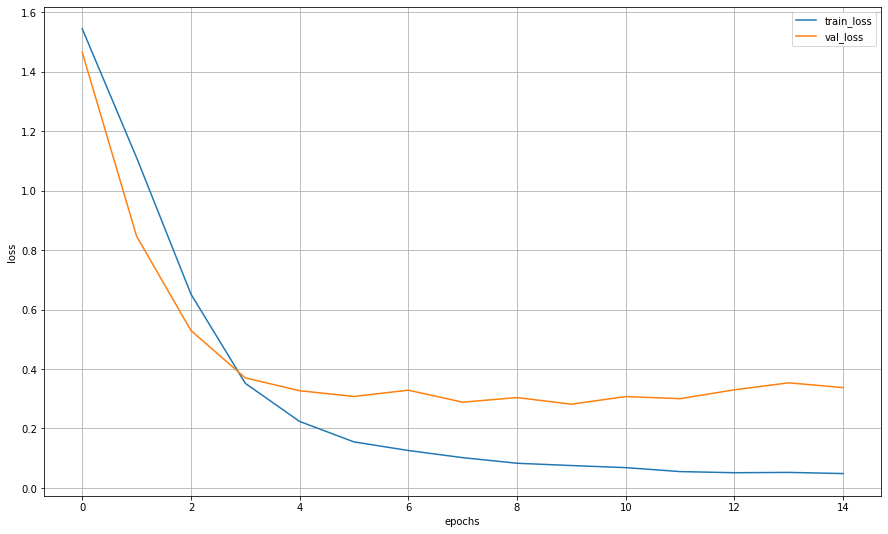

In [27]:
show_losses(train_losses, valid_losses)

In [28]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return seq, np.array(attn)

In [29]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [30]:
text = emotion_dataset["train"]["text"][7]  # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

C:\Users\lugre\AppData\Local\Temp/ipykernel_3060/1202738048.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
C:\Users\lugre\AppData\Local\Temp/ipykernel_3060/1202738048.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


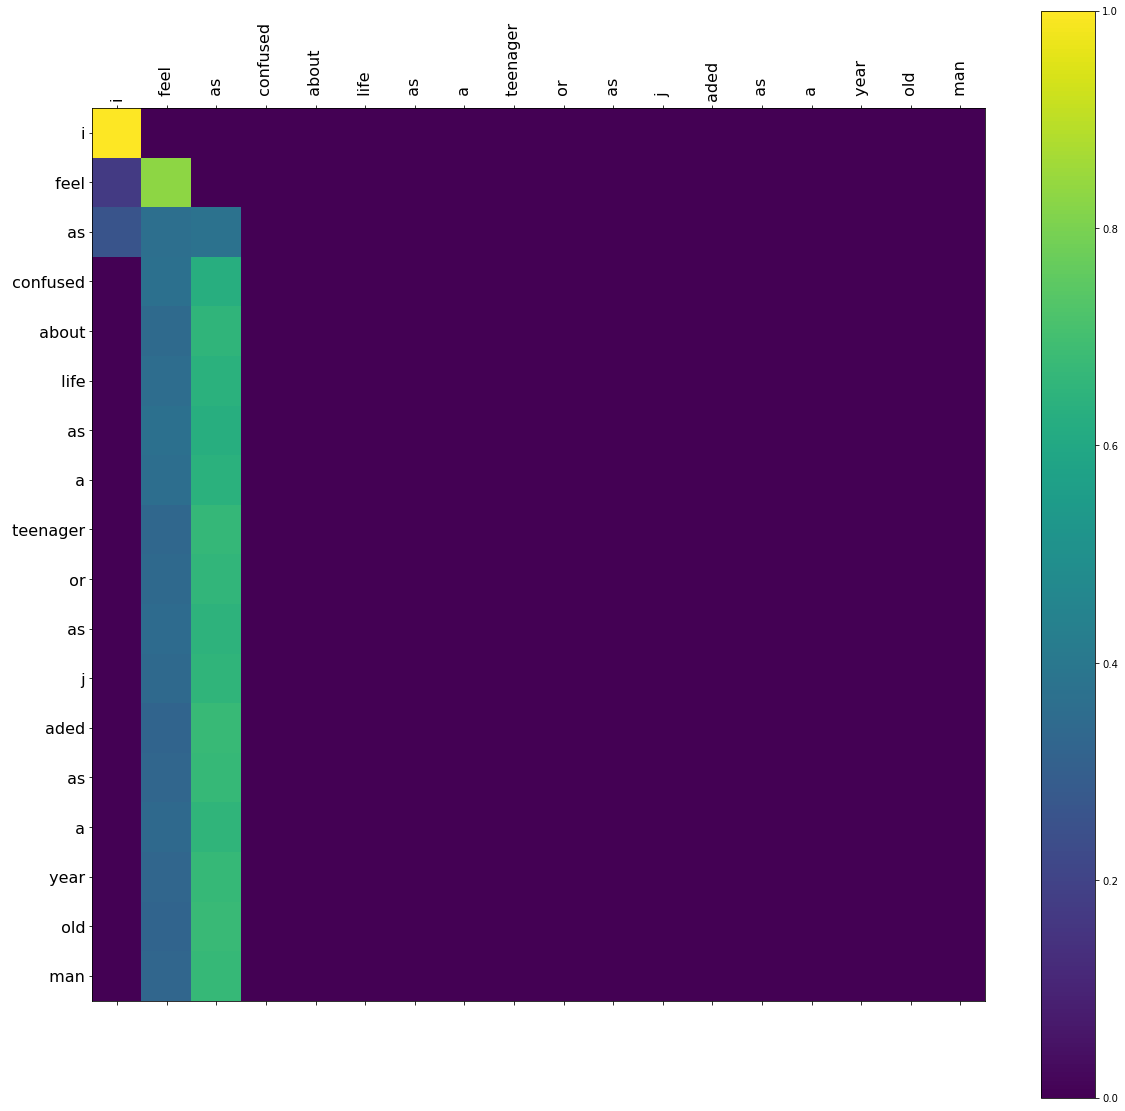

In [31]:
seq, attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(seq, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [32]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=num_classes
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
lr = 1e-5

optimizer = optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [34]:
num_epochs = 10
best_valid_acc = 0
train_losses = []
valid_losses = []

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    processed_data_train = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["attention_mask"].squeeze(1).to(device)
        target = batch["target"].to(device)

        output = model_1(input_ids=tokens, attention_mask=mask)

        loss = criterion(output.logits, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * target.size(0)
        processed_data_train += target.size(0)

    valid_loss = 0
    valid_acc = 0
    processed_data_val = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:

            tokens = batch["input_ids"].squeeze(1).to(device)
            mask = batch["attention_mask"].squeeze(1).to(device)
            target = batch["target"].to(device)

            output = model_1(input_ids=tokens, attention_mask=mask)

            loss = criterion(output.logits, target)

            preds = torch.argmax(output.logits.cpu(), 1)

            valid_loss += loss.item() * target.size(0)
            valid_acc += torch.sum(preds == target.cpu())
            processed_data_val += target.size(0)

    train_epoch_loss = train_loss / processed_data_train
    valid_epoch_loss = valid_loss / processed_data_val
    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)

    print(f"Epoch: {e+1}")
    print(f"Train Loss: {train_epoch_loss},"
          f"Valid Loss: {valid_epoch_loss},"
          f"Valid Acc: {valid_acc / processed_data_val}")

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_1.state_dict(), 'best-val-model_1.pt')
        print("The model was saved")

model_1.load_state_dict(torch.load('best-val-model_1.pt'))
print("The model was loaded")

# Testing
test_acc = 0
processed_data_test = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["attention_mask"].squeeze(1).to(device)
        target = batch["target"].to(device)

        output = model_1(input_ids=tokens, attention_mask=mask)
        preds = torch.argmax(output.logits.cpu(), 1)
        test_acc += torch.sum(preds == target.cpu())
        processed_data_test += target.size(0)

print(f"Test Acc: {test_acc / processed_data_test}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 1.5999692875146865,Valid Loss: 0.8676610097885132,Valid Acc: 0.6784999966621399
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2
Train Loss: 0.6200831456035376,Valid Loss: 0.2891525403261185,Valid Acc: 0.8980000019073486
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3
Train Loss: 0.2970725827813149,Valid Loss: 0.19647811871767043,Valid Acc: 0.9204999804496765
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4
Train Loss: 0.21105967640131712,Valid Loss: 0.17117537784576417,Valid Acc: 0.9254999756813049
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5
Train Loss: 0.17278572739474476,Valid Loss: 0.17183082804083824,Valid Acc: 0.9319999814033508
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6
Train Loss: 0.14875675265304744,Valid Loss: 0.1406247705221176,Valid Acc: 0.9375
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7
Train Loss: 0.1340475840624422,Valid Loss: 0.14682110595703124,Valid Acc: 0.9294999837875366


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8
Train Loss: 0.12266752398665995,Valid Loss: 0.13523880168795585,Valid Acc: 0.9319999814033508


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9
Train Loss: 0.11078730961633847,Valid Loss: 0.13368119283020496,Valid Acc: 0.9384999871253967
The model was saved


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10
Train Loss: 0.10716277211811394,Valid Loss: 0.1272322707772255,Valid Acc: 0.9394999742507935
The model was saved
The model was loaded
Test Acc: 0.9244999885559082


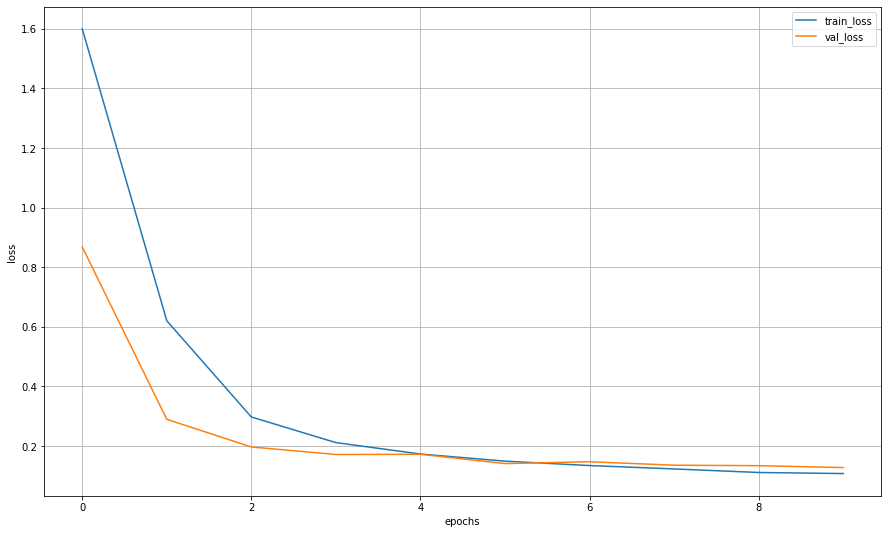

In [35]:
show_losses(train_losses, valid_losses)

In [36]:
text = emotion_dataset["train"]["text"][7]  # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

C:\Users\lugre\AppData\Local\Temp/ipykernel_3060/1202738048.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
C:\Users\lugre\AppData\Local\Temp/ipykernel_3060/1202738048.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


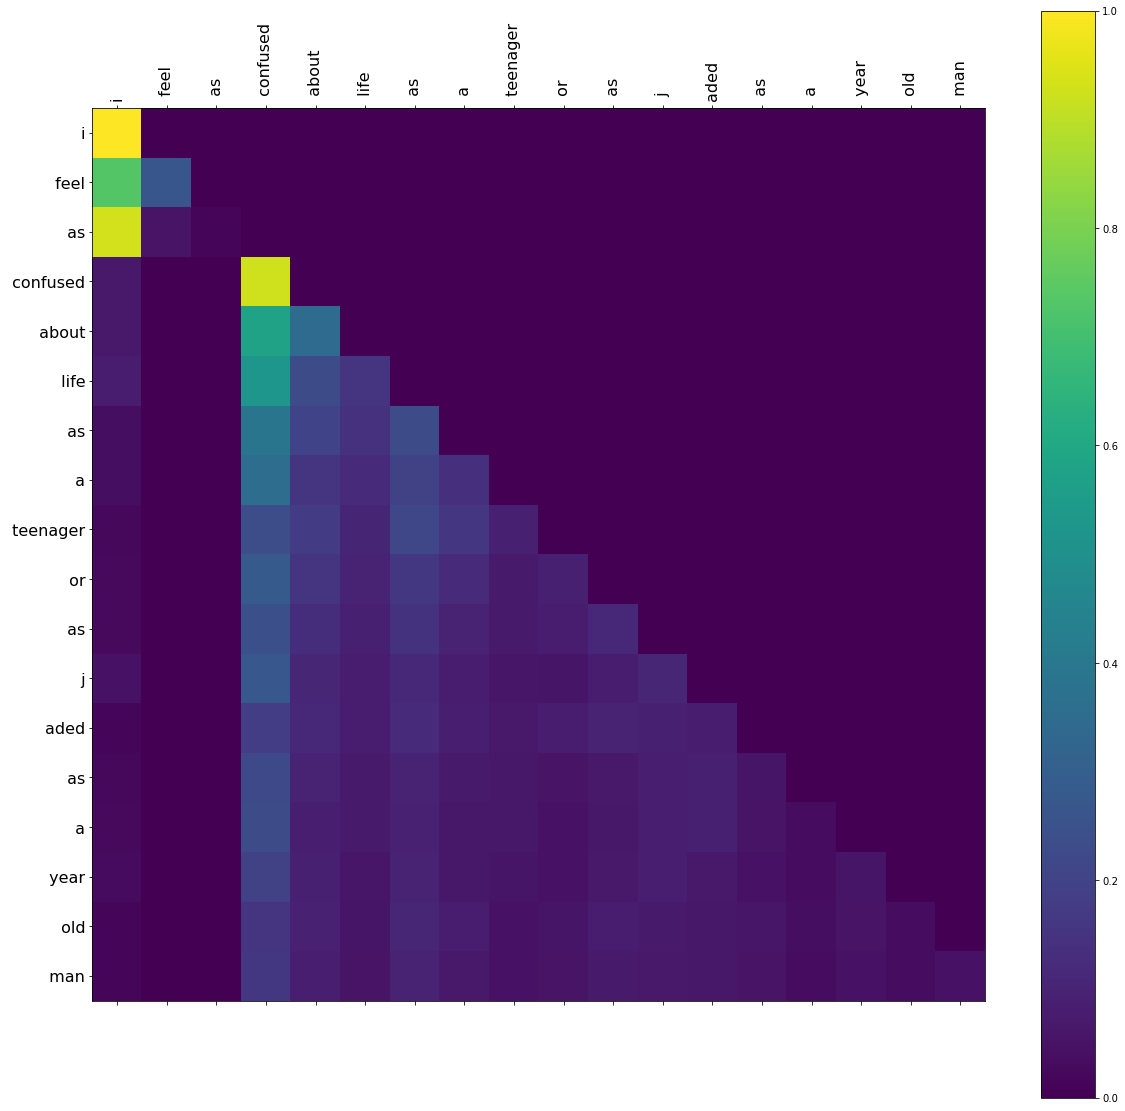

In [37]:
seq, attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(seq, attns[-1][0])

Модель GPT обученная с нуля достигла точности на тестовом датасете равной 0.9075. В свою очередь Fine Tuning модель показала точность 0.9244 на том же датасете при меньшем количестве эпох до сходимости. Сохранение моделей выполнялось по наилучшей валидационной точности, т.к. сохранение по лучшему валидационному лоссу показало качество хуже. Применение lr scheduler в моём случае не оправдало себя и не позволило повысить качество модели. Что касается карт внимания, на них отчётливо видно, что у Fine Tuning модели механизм attention развит значительно лучше и модель значительно больше уделяет внимание контексту и способна улавливать связь между словами находящимися в разной части предложения.
Чтобы более подробно изучить механизм внимания моделей, ниже выполнена bertviz-визуализация. На ней можно заметить, что модель обученная с нуля чаще всего фокусируется на начальных словах предложения, это особенно видно на 1 и на 5 слое. В то время как Fine Tuning модель более равномерно распределяет внимание между всеми словами в предложении находя существующие взаимосвязи между ними. Это полностью согласуется с выводами, сделанными на основе карт внимания.

In [38]:
!pip install bertviz
from bertviz import head_view, model_view

In [39]:
def call_html():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

## Модель обученная с нуля

In [40]:
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids'].to(device)
attention = model_0(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [41]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

<img src="https://cloud.telecombg.ru/index.php/s/mBsrGKPH95bp7wt/preview" />

## Fine Tuning модель

In [42]:
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids'].to(device)
attention = model_1(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [43]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

<img src="https://cloud.telecombg.ru/index.php/s/J7dtGn5oSQyWwaJ/preview" />